In [1]:
%cd /om/user/xboix/src/adversarial/Robustness

/om/user/xboix/src/adversarial/Robustness


In [2]:
experiment_name = "uci"
results_dir = '/vast/robustness/' + experiment_name + '/'

In [3]:
import seaborn as sns
sns.set_theme(style="ticks")
sns.set_context("poster")

import matplotlib.pyplot as plt
import pandas as pd
import pickle 
import os 

import numpy as np
import pandas
    
import runs.config_experiments_uci as run
experiment_list = run.config_experiments(results_dir, create_json=False)

2990 config files created


In [22]:
if not os.path.isfile('/vast/robustness/datasets/UCI/datasets_info.csv'):
    import json
    datasets = []
    for data_set in range(20,66):
        with open('/vast/robustness/configs_datasets/' + str(data_set) + '.json') as config_file:
            config = json.load(config_file)
            tmpX = np.shape(np.genfromtxt('/vast/robustness/datasets/UCI/imp_' + config["name_file"] 
                                 + '_' + "trainX.csv", delimiter=','))
            config["num_examples"] = tmpX[0]
            config["num_features"] = tmpX[1]
            datasets.append(config)
    df = pd.DataFrame(datasets) 
    df.to_csv('/vast/robustness/datasets/UCI/datasets_info.csv')
else:
    df = pd.read_csv('/vast/robustness/datasets/UCI/datasets_info.csv')

name_attacks = ["linf_pgd","l2_pgd", "linf_fgsm", "l2_fgm"]

In [137]:
list_entries = []
for idx_dd in range(20,35):
    
    dd = df[df.dataset_id==idx_dd].iloc[0]
    # Hash table of parameters
    parameters = {"epsilon": {}, "backbone": {}, "initial_learning_rate": {}, 
                  "robust_training": {}, "epsilon_pgd_training":{}}

    to_exclude = []
    experiment_list_tmp = [element for i, element in enumerate(experiment_list) if i not in to_exclude]
    for exp in experiment_list_tmp:
        if not exp["data_set"]==dd.dataset_id:
            continue

        for kk in parameters.keys():
            if exp[kk] in parameters[kk]:
                parameters[kk][exp[kk]].append(int(exp["model_name"]))
            else:
                parameters[kk][exp[kk]] = [int(exp["model_name"])]
                

    # For all methods, do cross-val and create an entry of the results
    backbones = ['MLP', 'MLP+pgd']
    robust_trainings = [True,False]

    for backbone in backbones:
        for robust_training in robust_trainings:
            if (backbone == 'Madry' and robust_training == True) or \
                (backbone == 'CNN+clipping' and robust_training == False):
                continue

            ids = list(set(parameters["backbone"][backbone]) & set(parameters["robust_training"][robust_training]))

            if backbone == 'MLP+pgd' and robust_training == True:
                continue

            if ids == []:
                continue
            print(ids)

            # Cross-validation among learning rates and epsilons:
            best_acc = 0.0
            best_id = -1
            for id in ids:
                acc = 0.0
                for attack in name_attacks:
                    file_name = results_dir + experiment_list[id]['model_name'] + '/results/acc_' + 'val' + '_' + attack + '.pkl'
                    if not os.path.isfile(file_name):
                        print("Missing!! " + file_name)
                        continue
                    with open(file_name, 'rb') as f:
                        tmp = pickle.load(f)

                    ave_acc = 0.0
                    for test_epsilon in list(tmp.keys()):
                        ave_acc += tmp[test_epsilon]
                    ave_acc = ave_acc / len(tmp.keys())
                    acc += ave_acc
                acc = acc / 2
                if acc>best_acc:
                    best_id = id
                    best_acc = acc

            entry = {"learning_rate": experiment_list[best_id]['initial_learning_rate'],
                    "backbone": experiment_list[best_id]['backbone'],
                    "robust_training": experiment_list[best_id]['robust_training'],
                    "epsilon": experiment_list[best_id]['epsilon'],
                    "epsilon_pgd_training": experiment_list[best_id]['epsilon_pgd_training'],
                    "num_features": dd.num_features,
                    "num_examples": dd.num_examples}

            dataset = "test"
            for attack in name_attacks:
                entry["dataset"] = dd.dataset_id - 20
                entry["attack"] = attack
                entry["experiment_id"] = best_id
                
                if not backbone == 'Madry':
                    with open(results_dir + experiment_list[best_id]['model_name'] + 
                              '/results/training_time.pkl', 'rb') as f:
                        tmp = pickle.load(f)
                    entry["images_per_second"] = np.mean(tmp) 
                    entry["std_images_per_second"] = np.std(tmp) 

                with open(results_dir + experiment_list[best_id]['model_name'] + '/results/acc_' + dataset + '_' + 
                    attack + '.pkl', 'rb') as f:
                    tmp = pickle.load(f)

                for test_epsilon in tmp.keys():
                    entry["test_epsilon"] = test_epsilon
                    entry["accuracy"] =  100*tmp[test_epsilon]
                    list_entries.append(entry.copy())
                  
df_results = pd.DataFrame.from_dict(list_entries) 





[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
Missing!! /vast/robustness/uci/7/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/uci/7/results/acc_val_l2_pgd.pkl
Missing!! /vast/robustness/uci/7/results/acc_val_linf_fgsm.pkl
Missing!! /vast/robustness/uci/7/results/acc_val_l2_fgm.pkl
Missing!! /vast/robustness/uci/9/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/uci/9/results/acc_val_l2_pgd.pkl
Missing!! /vast/robustness/uci/9/results/acc_val_linf_fgsm.pkl
Missing!! /vast/robustness/uci/9/results/acc_val_l2_fgm.pkl
[0, 1, 2, 3, 4]
Missing!! /vast/robustness/uci/0/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/uci/0/results/acc_val_l2_pgd.pkl
Missing!! /vast/robustness/uci/0/results/acc_val_linf_fgsm.pkl
Missing!! /vast/robustness/uci/0/results/acc_val_l2_fgm.pkl
[35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]
Missing!! /v

[585, 586, 587, 588, 589]
[640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639]
Missing!! /vast/robustness/uci/641/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/uci/641/results/acc_val_l2_pgd.pkl
Missing!! /vast/robustness/uci/641/results/acc_val_linf_fgsm.pkl
Missing!! /vast/robustness/uci/641/results/acc_val_l2_fgm.pkl
Missing!! /vast/robustness/uci/643/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/uci/643/results/acc_val_l2_pgd.pkl
Missing!! /vast/robustness/uci/643/results/acc_val_linf_fgsm.pkl
Missing!! /vast/robustness/uci/643/results/acc_val_l2_fgm.pkl
[655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684]
Missing!! /vast/robustness/uci/674/results/acc_val_linf_pgd.pkl
Missing!! /vast/robustness/uci/674/results/acc_val_l2_pgd.pkl
Missing!! /vast/robustness/uci/674/resul

In [138]:
df_final = df_results.groupby(['backbone', 'robust_training', 'dataset']).mean().reset_index()

for idx_dd in range(0,15):
    xx = df_final[df_final.dataset == idx_dd]
    df_final.loc[df_final.dataset == idx_dd,"accuracy"] = xx.accuracy / xx.accuracy.max()

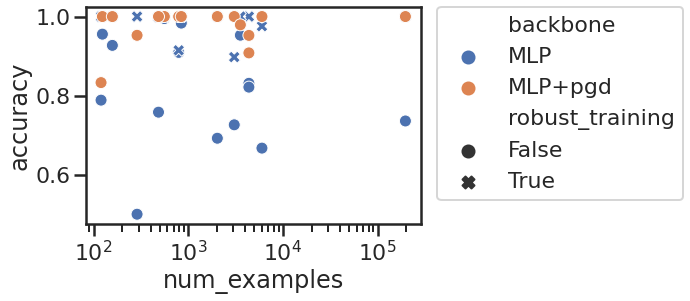

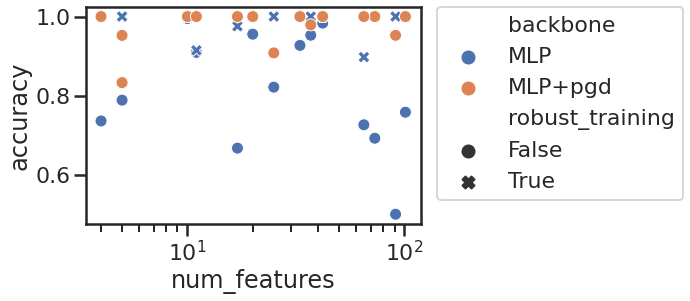

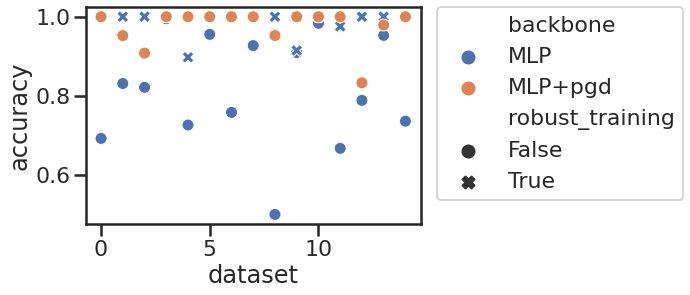

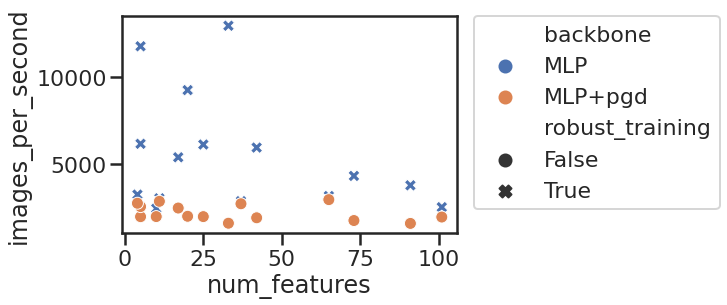

In [139]:
plt.figure()
sns.scatterplot(data=df_final, x="num_examples",y="accuracy",hue="backbone",style="robust_training")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xscale('log')

plt.figure()
sns.scatterplot(data=df_final, x="num_features",y="accuracy",hue="backbone",style="robust_training")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xscale('log')

plt.figure()
sns.scatterplot(data=df_final, x="dataset",y="accuracy",hue="backbone",style="robust_training")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.figure()
sns.scatterplot(data=df_final[~((df_final.robust_training==False)&(df_final.backbone=='MLP'))], 
                x="num_features",y="images_per_second",hue="backbone",style="robust_training")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


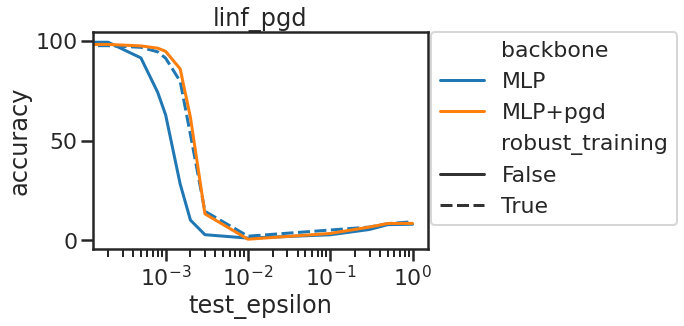

<Figure size 432x288 with 0 Axes>

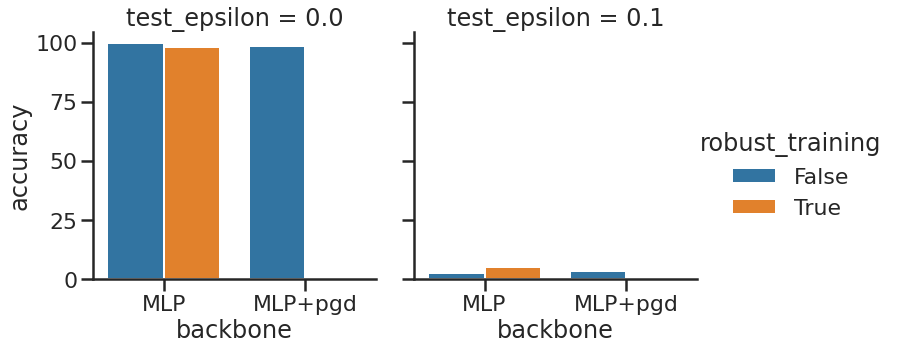

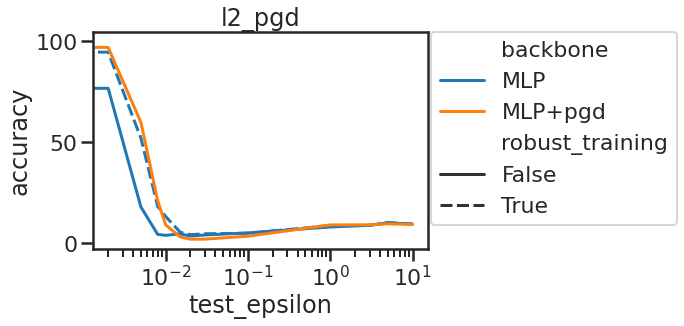

<Figure size 432x288 with 0 Axes>

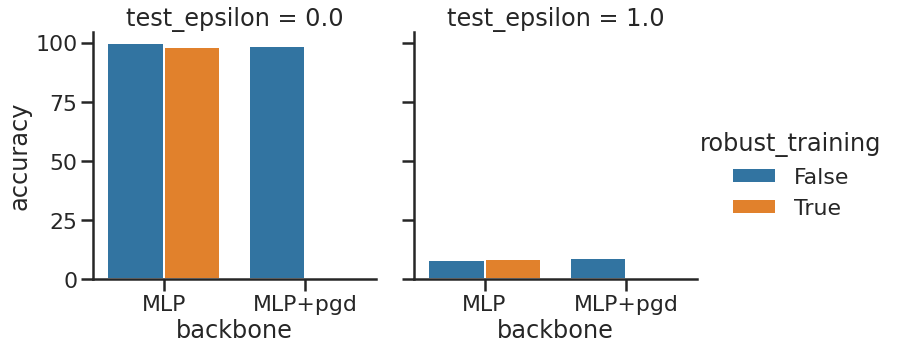

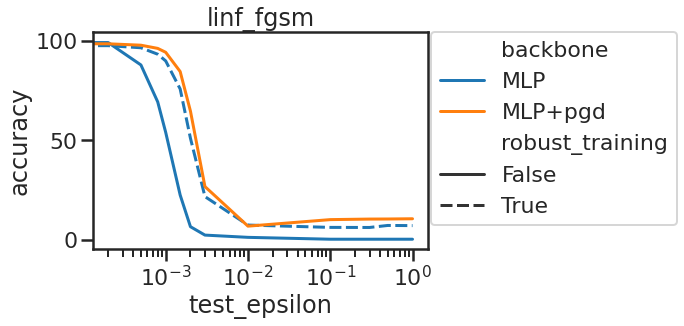

<Figure size 432x288 with 0 Axes>

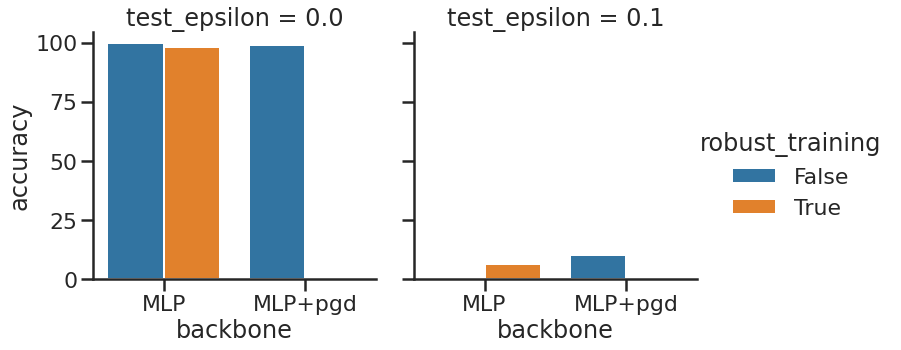

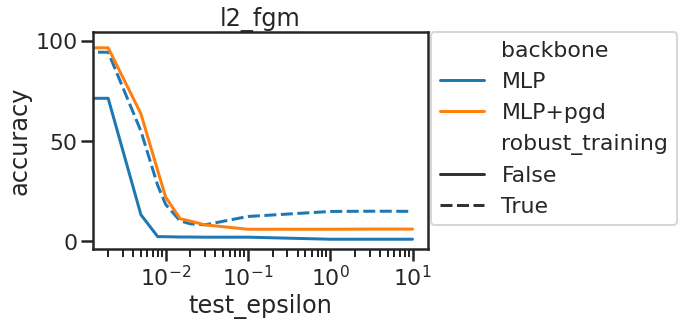

<Figure size 432x288 with 0 Axes>

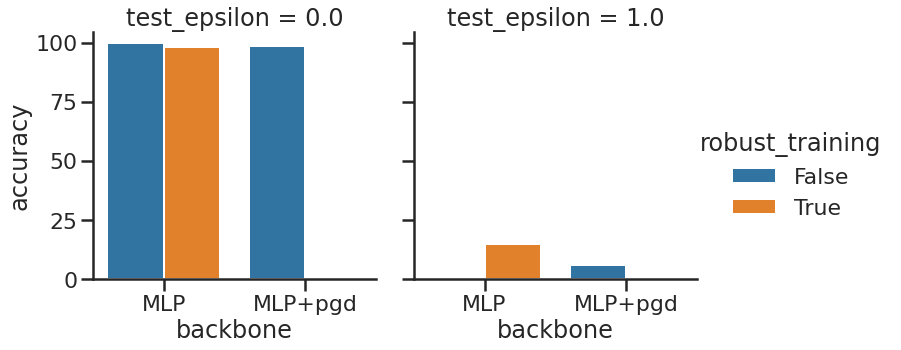

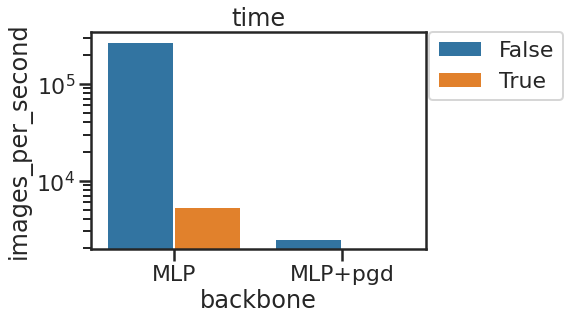

In [45]:

for attack in name_attacks:
    plt.figure()
    sns.lineplot(x="test_epsilon", y="accuracy",
                 hue="backbone",  style='robust_training', palette="tab10",
                 data=df_results[df_results.attack==attack]).set_title(attack)
    plt.xscale('log')
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

    plt.figure()
    epsilon = 0.1
    if attack == "l2_pgd" or attack == "l2_fgm" :
        epsilon = 1
    sns.catplot(x="backbone", y="accuracy",
                 hue="robust_training", col="test_epsilon", palette="tab10",kind="bar",
                 data=df_results[(df_results.test_epsilon == 0)| (df_results.test_epsilon == epsilon)][df_results.attack==attack])
    #plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

plt.figure()
sns.barplot(x="backbone", y="images_per_second",
             hue="robust_training", palette="tab10",
             data=df_results).set_title("time")
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

In [438]:
dataset = 20

# Hash table of parameters
parameters = {"epsilon": {}, "backbone": {}, "initial_learning_rate": {}, 
              "robust_training": {}, "epsilon_pgd_training":{}}

to_exclude = []
experiment_list_tmp = [element for i, element in enumerate(experiment_list) if i not in to_exclude]
for exp in experiment_list_tmp:
    if not exp["data_set"]==dataset:
        continue
        
    for kk in parameters.keys():
        if exp[kk] in parameters[kk]:
            parameters[kk][exp[kk]].append(int(exp["model_name"]))
        else:
            parameters[kk][exp[kk]] = [int(exp["model_name"])]

for kk in parameters.keys():
    print(kk)
    print(list(parameters[kk].keys()))

epsilon
[0.1, 0.0001, 1e-05, 0.001, 0.01, 1]
backbone
['MLP', 'MLP+pgd']
initial_learning_rate
[0.1, 0.01, 0.001, 0.0001, 1e-05]
robust_training
[False, True]
epsilon_pgd_training
[0.1, 0.0001, 1e-05, 0.001, 0.01, 1]


[0, 1, 2, 3, 4]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


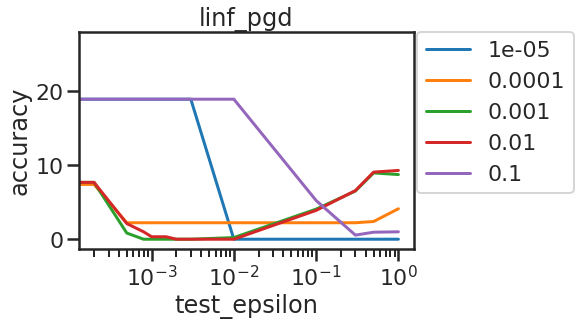

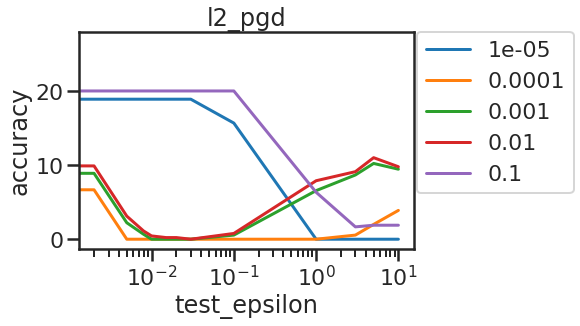

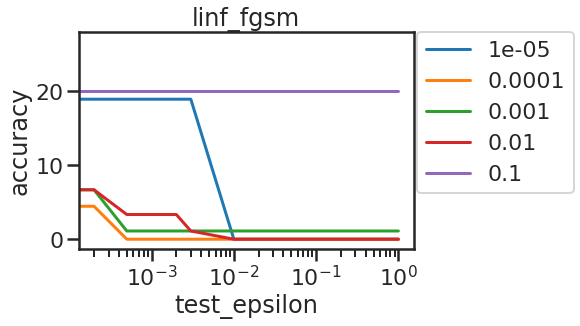

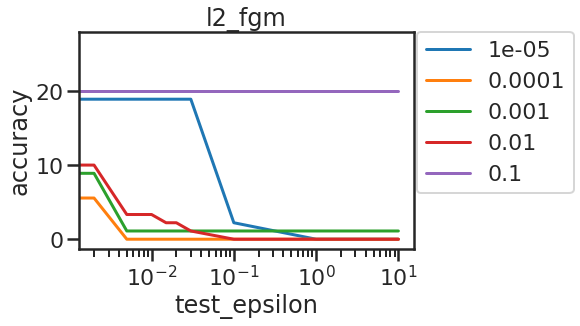

In [244]:
# Display learning rate impact
epsilon = 0.001
backbone = 'MLP'
robust_training = False
epsilon_pgd_training = 0.1

if robust_training:
    ids = list(set(parameters["backbone"][backbone]) & set(parameters["epsilon"][epsilon]) &
               set(parameters["robust_training"][robust_training]) 
               & set(parameters["epsilon_pgd_training"][epsilon_pgd_training]))
else:
    ids = list(set(parameters["backbone"][backbone]) &
            set(parameters["robust_training"][robust_training]) & 
               set(parameters["epsilon_pgd_training"][epsilon_pgd_training]))

print(ids)
list_entries = []
for id in ids:
    entry = {"learning_rate": experiment_list[id]['initial_learning_rate'],
            "backbone": experiment_list[id]['backbone'],
            "robust_training": experiment_list[id]['robust_training'],
            "epsilon": experiment_list[id]['epsilon']}
 
    for dataset in ["val", "test"]:
        for attack in name_attacks:
            entry["dataset"] = dataset
            entry["attack"] = attack
            with open(results_dir + experiment_list[id]['model_name'] + '/results/acc_' + dataset + '_' + 
                attack + '.pkl', 'rb') as f:
                tmp = pickle.load(f)
            
            for test_epsilon in tmp.keys():
                entry["test_epsilon"] = test_epsilon
                entry["accuracy"] =  100*tmp[test_epsilon]
                list_entries.append(entry.copy())
                
df = pd.DataFrame.from_dict(list_entries) 
for attack in name_attacks:
    plt.figure()
    sns.lineplot(x="test_epsilon", y="accuracy",
                 hue="learning_rate",  palette="tab10",
                 data=df[df.dataset=='test'][df.attack==attack]).set_title(attack)
    plt.xscale('log')
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)


29
29
29
29


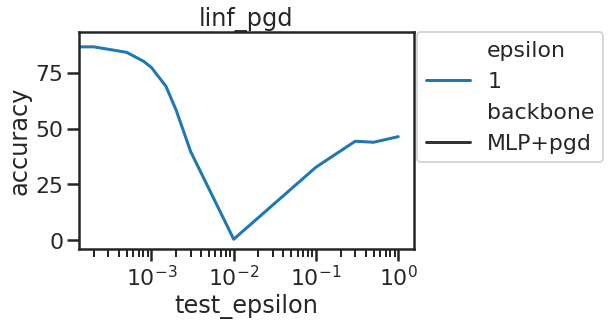

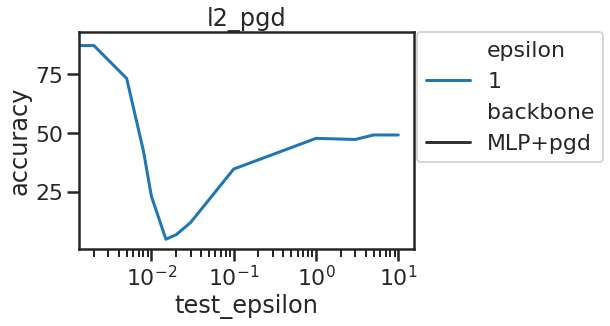

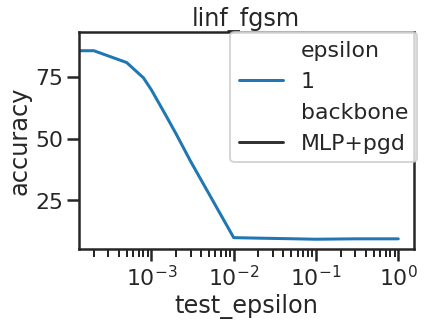

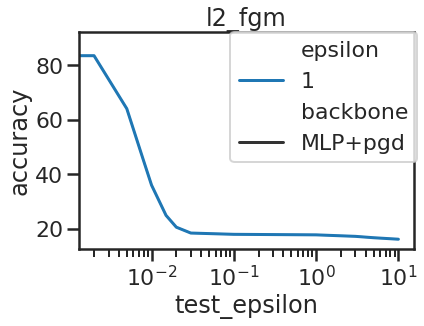

In [57]:
# Display epsilon
backbones = ['MLP+pgd']
robust_training = False
epsilon_pgd_training = 1e-3

list_entries = []
for backbone in backbones:
    for epsilon in list(parameters["epsilon"].keys()):

            
        if robust_training:
            ids = list(set(parameters["backbone"][backbone]) & set(parameters["epsilon"][epsilon]) &
                       set(parameters["robust_training"][robust_training])
                      & set(parameters["epsilon_pgd_training"][epsilon_pgd_training]))
        else:
            ids = list(set(parameters["backbone"][backbone]) &
                    set(parameters["robust_training"][robust_training])
                      & set(parameters["epsilon_pgd_training"][epsilon_pgd_training]))
            
        if len(ids)==0:
            continue
            
        # Cross-validation among learning rates:
        best_acc = 0.0
        best_id = -1
        for id in ids:
            acc = 0.0
            for attack in name_attacks:
                with open(results_dir + experiment_list[id]['model_name'] + '/results/acc_' + 'val' + '_' + 
                    attack + '.pkl', 'rb') as f:
                    tmp = pickle.load(f)
                
                ave_acc = 0.0
                for test_epsilon in list(tmp.keys())[:2]:
                    ave_acc += tmp[test_epsilon]
                ave_acc = ave_acc / len(tmp.keys())
                acc += ave_acc
            acc = acc / 2
            if acc>best_acc:
                best_id = id
                best_acc = acc
                
        print(best_id)
        entry = {"learning_rate": experiment_list[best_id]['initial_learning_rate'],
                "backbone": experiment_list[best_id]['backbone'],
                "robust_training": experiment_list[best_id]['robust_training'],
                "epsilon": experiment_list[best_id]['epsilon']}

        dataset = "test"
        for attack in name_attacks:
            entry["dataset"] = dataset
            entry["attack"] = attack
            with open(results_dir + experiment_list[best_id]['model_name'] + '/results/acc_' + dataset + '_' + 
                attack + '.pkl', 'rb') as f:
                tmp = pickle.load(f)

            for test_epsilon in tmp.keys():
                entry["test_epsilon"] = test_epsilon
                entry["accuracy"] =  100*tmp[test_epsilon]
                list_entries.append(entry.copy())
                
df = pd.DataFrame.from_dict(list_entries) 

for attack in name_attacks:
    plt.figure()
    sns.lineplot(x="test_epsilon", y="accuracy",
                 hue="epsilon",  style='backbone', palette="tab10",
                 data=df[df.attack==attack]).set_title(attack)
    plt.xscale('log')
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)


[1825, 1826, 1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843, 1844, 1845, 1846, 1847, 1848, 1849, 1850, 1851, 1852, 1853, 1854]
1840
[1824, 1820, 1821, 1822, 1823]
1824
[1855, 1856, 1857, 1858, 1859, 1860, 1861, 1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870, 1871, 1872, 1873, 1874, 1875, 1876, 1877, 1878, 1879, 1880, 1881, 1882, 1883, 1884]
1864


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


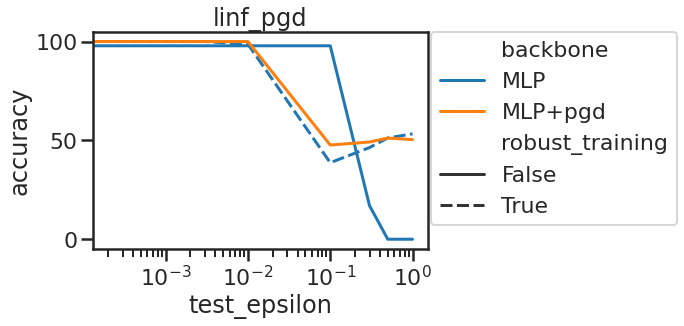

<Figure size 432x288 with 0 Axes>

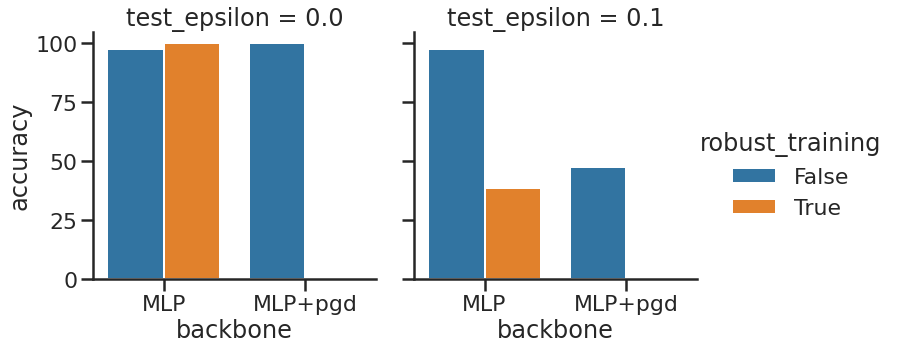

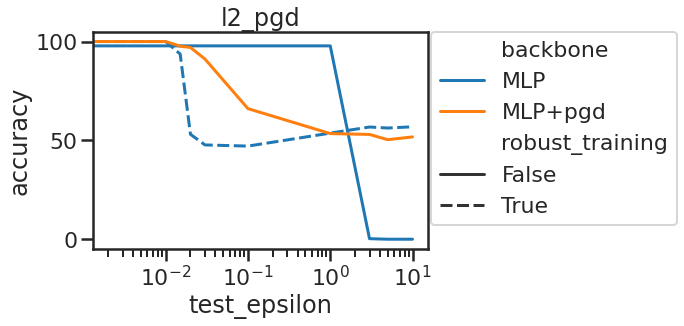

<Figure size 432x288 with 0 Axes>

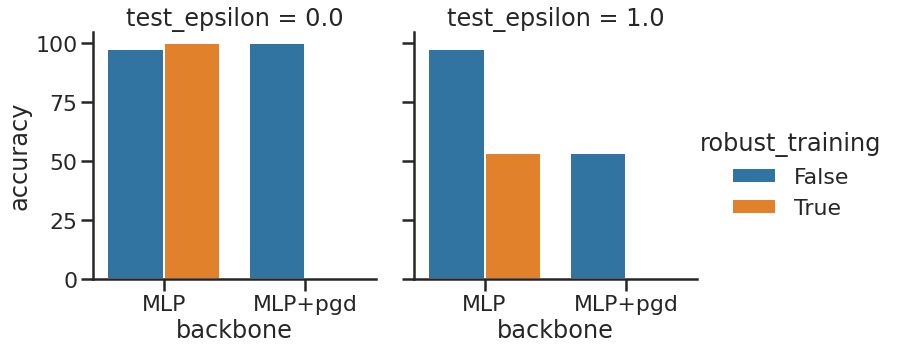

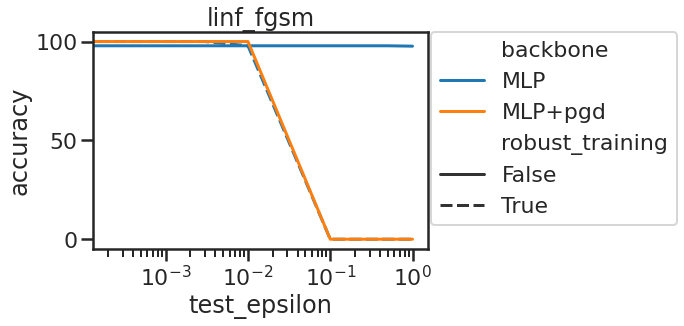

<Figure size 432x288 with 0 Axes>

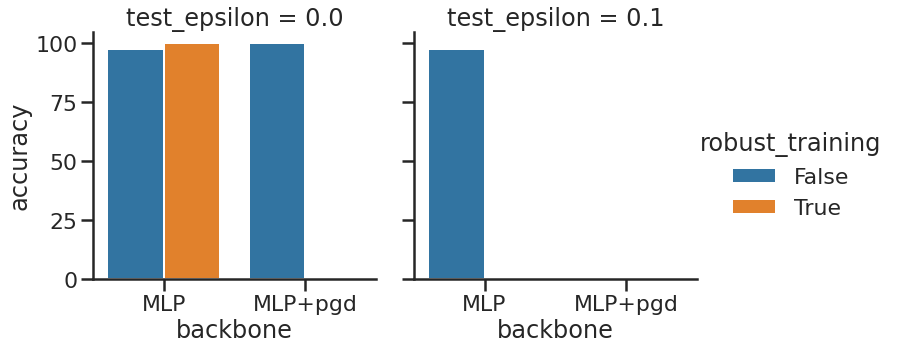

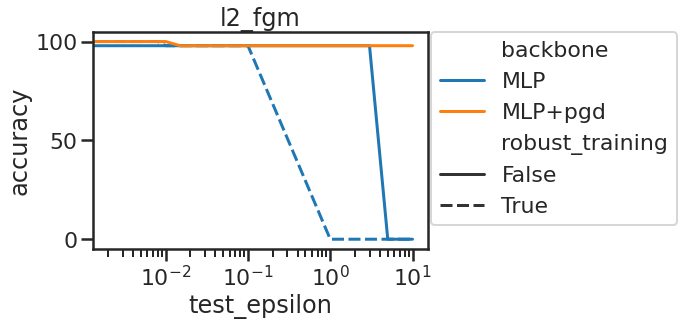

<Figure size 432x288 with 0 Axes>

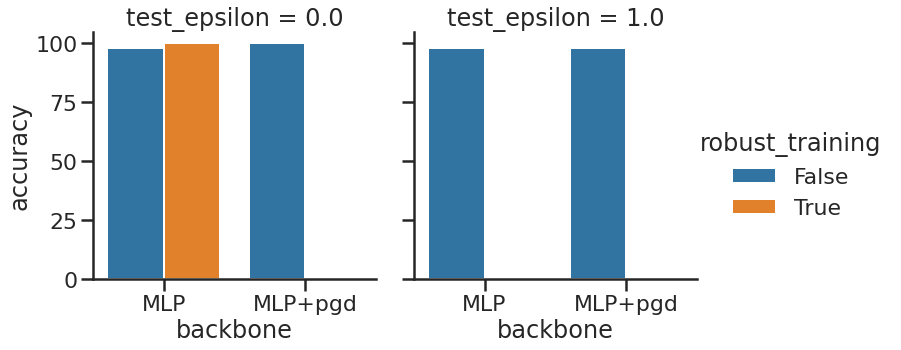

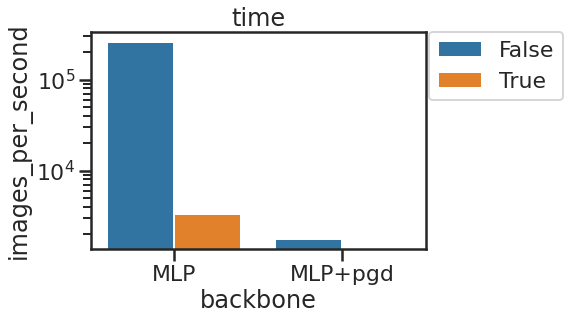

In [386]:
# Display best
backbones = ['MLP', 'MLP+pgd']
robust_trainings = [True,False]

list_entries = []
for backbone in backbones:
    for robust_training in robust_trainings:
        if (backbone == 'Madry' and robust_training == True) or \
            (backbone == 'CNN+clipping' and robust_training == False):
            continue
            
        ids = list(set(parameters["backbone"][backbone]) & set(parameters["robust_training"][robust_training]))
        
        if backbone == 'MLP+pgd' and robust_training == True:
            continue
            
        if ids == []:
            continue
        print(ids)
        
        # Cross-validation among learning rates:
        best_acc = 0.0
        best_id = -1
        for id in ids:
            #if (experiment_list[id]['backbone'] == 'CNN+pgd') and experiment_list[id]["epsilon_pgd_training"] == 0.3:
            #    continue 
            acc = 0.0
            for attack in name_attacks:
                with open(results_dir + experiment_list[id]['model_name'] + '/results/acc_' + 'val' + '_' + 
                    attack + '.pkl', 'rb') as f:
                    tmp = pickle.load(f)
                
                ave_acc = 0.0
                for test_epsilon in list(tmp.keys())[:6]:
                    ave_acc += tmp[test_epsilon]
                ave_acc = ave_acc / len(tmp.keys())
                acc += ave_acc
            acc = acc / 2
            if acc>best_acc:
                best_id = id
                best_acc = acc

        entry = {"learning_rate": experiment_list[best_id]['initial_learning_rate'],
                "backbone": experiment_list[best_id]['backbone'],
                "robust_training": experiment_list[best_id]['robust_training'],
                "epsilon": experiment_list[best_id]['epsilon']}

        dataset = "test"
        print(best_id)
        for attack in name_attacks:
            entry["dataset"] = dataset
            entry["attack"] = attack
            
            if not backbone == 'Madry':
                with open(results_dir + experiment_list[best_id]['model_name'] + 
                          '/results/training_time.pkl', 'rb') as f:
                    tmp = pickle.load(f)
                entry["images_per_second"] = np.mean(tmp) 
                entry["std_images_per_second"] = np.std(tmp) 
                
            with open(results_dir + experiment_list[best_id]['model_name'] + '/results/acc_' + dataset + '_' + 
                attack + '.pkl', 'rb') as f:
                tmp = pickle.load(f)

            for test_epsilon in tmp.keys():
                entry["test_epsilon"] = test_epsilon
                entry["accuracy"] =  100*tmp[test_epsilon]
                list_entries.append(entry.copy())
                  
df = pd.DataFrame.from_dict(list_entries) 

for attack in name_attacks:
    plt.figure()
    sns.lineplot(x="test_epsilon", y="accuracy",
                 hue="backbone",  style='robust_training', palette="tab10",
                 data=df[df.attack==attack]).set_title(attack)
    plt.xscale('log')
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

    plt.figure()
    epsilon = 0.1
    if attack == "l2_pgd" or attack == "l2_fgm" :
        epsilon = 1
    sns.catplot(x="backbone", y="accuracy",
                 hue="robust_training", col="test_epsilon", palette="tab10",kind="bar",
                 data=df[(df.test_epsilon == 0)| (df.test_epsilon == epsilon)][df.attack==attack])
    #plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

plt.figure()
sns.barplot(x="backbone", y="images_per_second",
             hue="robust_training", palette="tab10",
             data=df).set_title("time")
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

In [42]:
experiment_list[241]

{'_comment': '=====ADVERSARIAL EXAMPLES CONFIGURATION=====',
 'model_name': '241',
 'restart': False,
 'data_set': 'mnist',
 'num_classes': 10,
 'backbone': 'CNN+pgd',
 'l1_size': 200,
 'l2_size': 200,
 'random_seed': 4557077,
 'robust_training': True,
 'max_num_training_steps': 10000,
 'num_output_steps': 500,
 'training_size': 50000,
 'validation_size': 1000,
 'testing_size': 10000,
 'training_batch_size': 256,
 'initial_learning_rate': 0.001,
 'batch_decrease_learning_rate': 5,
 'eval_attack_during_training': True,
 'epsilon': 0.05,
 'increasing_epsilon': False,
 'pgd_training': True,
 'epsilon_pgd_training': 0.3}

In [87]:
df[df.backbone=="Madry"][df.attack=="linf_pgd"][df.test_epsilon == 0.3 ]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,learning_rate,backbone,robust_training,epsilon,dataset,attack,test_epsilon,accuracy,images_per_second,std_images_per_second
218,0.001,Madry,True,0.1,test,linf_pgd,0.3,93.515625,NaN,NaN
270,0.001,Madry,True,0.1,test,linf_pgd,0.3,93.515625,NaN,NaN


In [107]:
df[df.backbone=="Madry"][df.attack=="linf_fgsm"][df.test_epsilon == 0.3 ]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,learning_rate,backbone,robust_training,epsilon,dataset,attack,test_epsilon,accuracy,images_per_second,std_images_per_second
244,0.001,Madry,True,0.1,test,linf_fgsm,0.3,95.507812,NaN,NaN
296,0.001,Madry,True,0.1,test,linf_fgsm,0.3,95.507812,NaN,NaN
